In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize
from pathlib import Path
from IPython.display import clear_output

In [2]:
# Images directory

figsdir = Path.cwd() / 'ex3figs'
figsdir.mkdir(parents=True, exist_ok=True);

In [3]:
# Data directory

datadir = Path.cwd() / 'data/ex3'

# Multi-class classification

In [4]:
# Load data

data = loadmat(datadir / 'ex3data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [5]:
x = np.c_[np.ones(data['X'].shape[0]), data['X']]
y = data['y']

print('x: {} (intercept incl.)\ny: {}'.format(x.shape, y.shape))

x: (5000, 401) (intercept incl.)
y: (5000, 1)


In [6]:
def display_data(x):
    n = np.sqrt(x.shape[0]).astype('int')
    cols = np.sqrt(x.shape[1]).astype('int')
    img = np.zeros((n, n*cols, cols))
    
    for i in range(n):
        in_idx = n * i
        fin_idx = n * (i + 1)
        img[i] = x[in_idx:fin_idx].reshape(-1, cols)
        
    img = np.concatenate([img[i] for i in range(n)], axis=1)
    
    plt.figure().set_size_inches(5, 5)
    plt.imshow(img.T)

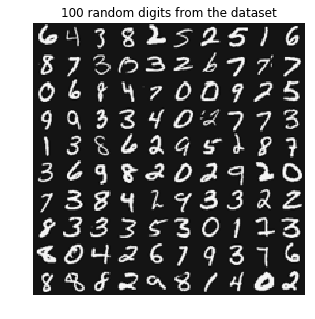

In [7]:
# Display data

sample = np.random.choice(x.shape[0], 100)

display_data(x[sample, 1:])
plt.title('100 random digits from the dataset')
plt.set_cmap('Greys_r')
plt.axis('off')

plt.savefig(figsdir / 'data.png', bbox_inches='tight')

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
def cost_function(theta, x, y, reg=0):
    h = sigmoid(x.dot(theta))
    return -(np.sum(y.T.dot(np.log(h)) + (1 - y.T).dot(np.log(1 - h))) - (reg/2) * np.sum(np.square(theta[1:]))) / len(x)

In [10]:
def gradient(theta, x, y, reg=0):
    h = sigmoid(x.dot(theta.reshape(-1, 1)))
    grad = np.zeros(theta.shape)
    
    grad[0] = np.sum(x[:, 0].T.dot(h - y)) / len(x)
    grad[1:] = ((x[:, 1:].T.dot(h - y)).ravel() + reg * theta[1:]) / len(x)
    
    return grad

In [11]:
theta_t = np.array([-2, -1, 1, 2])
x_t = np.c_[np.ones(5), ((np.arange(15) + 1) / 10).reshape(3,5).T]
y_t = np.array([1, 0, 1, 0, 1]).reshape(-1, 1)
reg_t = 3
J = cost_function(theta_t, x_t, y_t, reg_t)
grad = gradient(theta_t, x_t, y_t, reg_t)

print('Cost: {}'.format(J))
print('Expected cost: 2.534819')
print('Gradient: {}'.format(grad))
print('Expected gradient: [ 0.146561 -0.548558 0.724722 1.398003]')

Cost: 2.534819396109744
Expected cost: 2.534819
Gradient: [ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradient: [ 0.146561 -0.548558 0.724722 1.398003]


In [12]:
def one_vs_all(x, y, num_labels, reg):
    initial_theta = np.zeros(x.shape[1])
    all_theta = np.zeros((num_labels, x.shape[1]))
    
    for c in range(1, num_labels + 1):
        res = minimize(cost_function, initial_theta, args=(x, y == c, reg), jac=gradient)
        all_theta[c - 1, :] = res.x
        print('Class {:02d} | Cost: {}'.format(c, res.fun))
    
    return all_theta

In [13]:
num_labels = 10
reg = 0.1
theta = one_vs_all(x, y, num_labels, reg)

Class 01 | Cost: 0.013128373669473524
Class 02 | Cost: 0.050810113904854314
Class 03 | Cost: 0.05761164119356354
Class 04 | Cost: 0.033074850125163285
Class 05 | Cost: 0.05446564358080312
Class 06 | Cost: 0.01826457697210091
Class 07 | Cost: 0.03065318039140119
Class 08 | Cost: 0.078457336527021
Class 09 | Cost: 0.07119337754641947
Class 10 | Cost: 0.008583336445757768


In [14]:
def predict_one_vs_all(x, theta):
    return np.argmax(sigmoid(x.dot(theta.T)), axis=1) + 1

In [15]:
pred = predict_one_vs_all(x, theta)
print('Training set accuracy (multi-class logistic regression): {:.02f}%'.format(np.mean(pred == y.ravel()) * 100))

Training set accuracy (multi-class logistic regression): 96.48%


# Neural network

In [16]:
# Load weights

weights = loadmat(datadir / 'ex3weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [17]:
theta1 = weights['Theta1']
theta2 = weights['Theta2']
print('Theta1: {}\nTheta2: {}'.format(theta1.shape, theta2.shape))

Theta1: (25, 401)
Theta2: (10, 26)


In [18]:
def predict_nn(theta1, theta2, x):
    a2 = np.c_[np.ones(x.shape[0]), sigmoid(x.dot(theta1.T))]
    a3 = sigmoid(a2.dot(theta2.T))
    return np.argmax(a3, axis=1) + 1

In [19]:
pred = predict_nn(theta1, theta2, x)
print('Training set accuracy (neural network): {:.02f}%'.format(np.mean(pred == y.ravel()) * 100))

Training set accuracy (neural network): 97.52%


In [20]:
def display_digit(i):
    digit_map = x[i, 1:].reshape(-1, 20)
    plt.imshow(digit_map.T, cmap='Greys_r')
    plt.axis('off')
    plt.show(block=False)

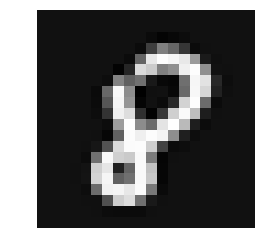

Predicted: [8]
Correct: [8]


In [ ]:
perm = np.random.permutation(len(x))
for i in perm:
    clear_output(wait=True)
    display_digit(i)
    print('Predicted: {}'.format(predict_nn(theta1, theta2, x[i].reshape(1, 401))), flush=True)
    print('Correct: {}'.format(y[i]), flush=True)
    inp = input('Enter to continue or q to quit: ')
    if inp == 'q':
        break